This notebook will try to sort out issues with the waviness in the CF part when there's a loong Cf and a short FM. I'm currently using scipy.signal.sweep_poly to generate flexible frequency modulations. It works by fitting the instantaneous frequency over time to a polynomial and then using that to create the waveform. 

The method mostly works, but fails in the above cases. Essentially, when the frequency sweep suddenly increases its rate - the polynomial fit kind of fails. I need to figure out some hacks/alternatives to this. It'd be sad to throw out such cases just because my simulated calls are bad!!!

-- Thejasvi Beleyur, March 2020

In [416]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.signal as signal 

from measure_horseshoe_bat_calls.view_horseshoebat_call import *

In [189]:
%matplotlib notebook

In [190]:
## A copy of make_one_CFcall from measure_horseshoe_bat_calls -- which will be heavily modified. 
def make_one_CFcall(call_durn, fm_durn, cf_freq, fs, call_shape, **kwargs):
    '''A test function used to check how well the segmenting+measurement
    functions in the module work. 
    
    Parameters
    ----------
    call_durn : float
    fm_durn : float
    cf_freq : float
    fs : float
    call_shape : str
        One of either 'staplepin' OR 'rightangle'
    fm_bandwidth : float, optional
        FM bandwidth in Hz.


    Returns
    --------
    cfcall : np.array
        The synthesised call. 

    Raises
    -------
    ValueError
        If a call_shape that is not  'staplepin' OR 'rightangle' is given

    Notes
    ------
    This is not really the besssst kind of CF call to test the functions on, 
    but it works okay. The CF call is made by using the poly spline function 
    and this leads to weird jumps in frequency especially around the CF-FM
    junctions. Longish calls with decently long FM parts look fine, but calls
    with very short FM parts lead to rippling of the frequency. 
    '''
    # choose an Fm start/end fr equency :
    FM_bandwidth = np.arange(2,20)
    fm_bw = kwargs.get('fm_bandwidth', np.random.choice(FM_bandwidth, 1)*10.0**3)
    start_f = cf_freq - fm_bw
    # 
    polynomial_num = 25
    t = np.linspace(0, call_durn, int(call_durn*fs))
    # define the transition points in the staplepin
    freqs = np.tile(cf_freq, t.size)
    numfm_samples = int(fs*fm_durn)
    if call_shape == 'staplepin':       
        freqs[:numfm_samples] = np.linspace(start_f,cf_freq,numfm_samples, endpoint=True)
        freqs[-numfm_samples:] = np.linspace(cf_freq,start_f,numfm_samples, endpoint=True)
        p = np.polyfit(t, freqs, polynomial_num)

    elif call_shape == 'rightangle':
        # alternate between rising and falling right angle shapes
        rightangle_type = np.random.choice(['rising','falling'],1)
        if rightangle_type == 'rising':
            freqs[:numfm_samples] = np.linspace(cf_freq,start_f,numfm_samples, endpoint=True)
        elif rightangle_type == 'falling':
            freqs[-numfm_samples:] = np.linspace(cf_freq,start_f,numfm_samples, endpoint=True)
        p = np.polyfit(t, freqs, polynomial_num)

    else: 
        raise ValueError('Wrong input given')
      
    cfcall = signal.sweep_poly(t, p)

    #windowing = np.random.choice(['hann', 'nuttall', 'bartlett','boxcar'], 1)[0]
    windowing= 'boxcar'
    cfcall *= signal.get_window(windowing, cfcall.size)
    cfcall *= signal.tukey(cfcall.size, 0.01)
    return cfcall

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


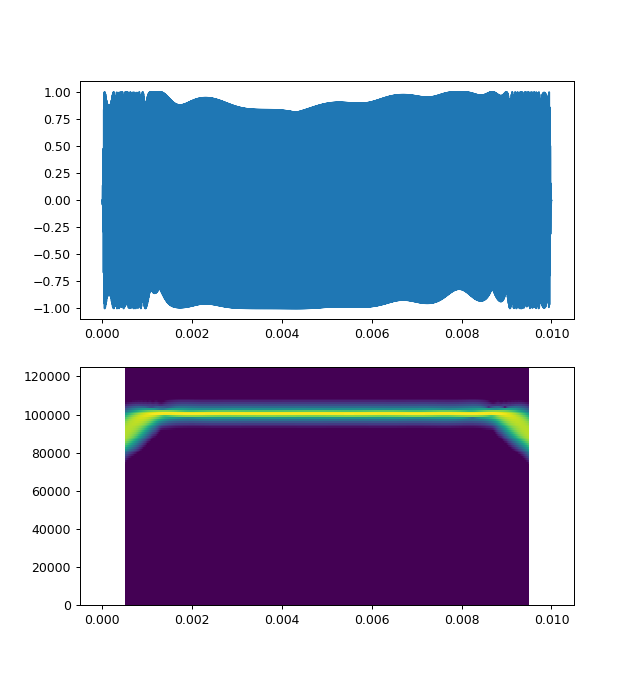

(0, 125000)

In [192]:
fs = 500000
egcall = make_one_CFcall(0.01, 0.001, cf_freq=100000.0, fs=fs, call_shape='staplepin',
                               fm_bandwidth=20000)
w, s = visualise_call(egcall, fs, fft_size=512);
s.set_ylim(0,125000)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


<IPython.core.display.Javascript object>


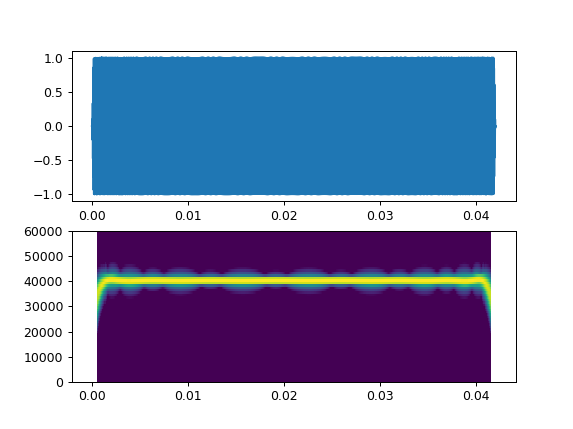

(0, 60000)

In [195]:
egcall = make_one_CFcall(0.042, 0.001, cf_freq=40000.0, fs=fs, call_shape='staplepin',
                               fm_bandwidth=15000)
w, s = visualise_call(egcall, fs, fft_size=512);
s.set_ylim(0,60000)

In [8]:
fs

500000

In [94]:
import scipy.interpolate as interpolate

In [432]:
# thanks to Paul Panzer
# https://stackoverflow.com/questions/47664360/list-of-frequencies-in-time-to-signal-in-python

def make_cffm_joint_profile(cf, fm_slope, fs, joint_type='down', **kwargs):
    '''Makes a 'joint' in the frequency profile at transition betweent eh CF and FM parts

    Parameters
    ----------
    cf : float>0
    fm_slope : float>0
    fs : float>0
    poly_order : int, optional
        Polynomial order to be used by np.polyfit
    joint_duration : float, optional 
        The length of the CF and FM joints.
    Returns 
    -------
    freq_profile : np.array
        Frequency at each sample point over the 2*joint_duration 
        length array.
    '''
    poly_order  = kwargs.get('poly_order', 10)
    joint_duration = kwargs.get('joint_duration', 0.0005)

    fm_join_end = cf - fm_slope*joint_duration
    lower_fs = fs*0.75
    
    cf_part = np.tile(cf, int(lower_fs*joint_duration))
    fm_part = np.linspace(cf, fm_join_end, int(lower_fs*joint_duration))
    freqs = np.concatenate((cf_part, fm_part))
    time_lowfs = np.linspace(0, 2*joint_duration, freqs.size)

    fit_joint = np.poly1d(np.polyfit(time_lowfs, freqs, poly_order))
    
    time_highres = np.linspace(0, 2*joint_duration, int(fs*2*joint_duration))
    freq_profile = fit_joint(time_highres)
    if joint_type=='up':
        freq_profile = np.flip(freq_profile)
    return freq_profile, joint_duration

def make_FM_with_joint(fm_properties, cf_start, fs, **kwargs):
    '''Outputs an FM segment with the CF part of the joint attached. 
    Think of it like a bent :math:`\Gamma` with the part coming down 
    at an angle instead. 

    Parameters
    ----------
    fm_properties : tuple
        Tuple with format (end_frequency_Hz, fm_duration_seconds)
    cf_start : float
        CF frequency

    See Also
    --------
    make_cffm_joint_profile
    
    Returns
    -------
    fm_with_joint : np.array
        Frequency profile of the FM segment with a bit of the CF part
        of the joint sticking out. 
    '''
    fm_terminal, fm_duration = fm_properties
    fm_bw = cf_start - fm_terminal
    fm_slope = fm_bw/fm_duration


    joint_freq_profile, min_dur = make_cffm_joint_profile(cf_start, fm_slope, fs, 
                                                      **kwargs)
    # fm post/pre joint
    fm_time = np.linspace(0, fm_duration-min_dur, int(fs*(fm_duration-min_dur)))
    start_end_frequency = [joint_freq_profile[-1], fm_terminal]
    fm_post_joint = np.interp(fm_time, [0, fm_duration-min_dur],
                                   [joint_freq_profile[-1], fm_terminal])
    
    fm_with_join = np.concatenate((joint_freq_profile,fm_post_joint))
    return fm_with_join, min_dur

def make_call_frequency_profile(call_properties, fs, **kwargs):
    '''
    
    Parameters
    ----------
    call_properties : dictionary
        With keys : 'cf', 'upfm', 'downfm'
        Each key has a tuple entry with a frequency and a duration value
        eg. cp = {'cf':(100000, 0.01),
                  'upfm':{50000, 0.005},
                  'downfm':{20000, 0.003}}
        This corresponds to a call with an upfm starting at 50kHz of 5ms
        and a CF at 100kHz of 10ms, followed by a downfm ending at 20kHz of 3ms. 

    fs : float
    
    Returns
    --------
    final_frequency_profile : np.array
        The call frequency profile.
    
    See Also
    --------
    make_FM_with_joint
    
                  

    '''
    cf_freq, cf_durn = call_properties['cf']

    double_fm_call = np.all([call_properties.get('upfm')!=None, call_properties.get('downfm')!=None,])
    if double_fm_call:
        upfm_freq_profile, joint_durn = make_FM_with_joint(call_properties['upfm'],
                                               cf_freq,fs,
                                                           **kwargs)
        upfm_freq_profile = upfm_freq_profile[::-1]
        downfm_freq_profile, joint_durn = make_FM_with_joint(call_properties['downfm'],
                                               cf_freq, fs,
                                               **kwargs)

        effective_cf_durn = cf_durn - 2*joint_durn
        cf_time_effective = np.linspace(0,effective_cf_durn,1000)
        rough_cf_freq_profile = np.concatenate( (np.array([upfm_freq_profile[-1]]),
                                                 np.tile(cf_freq, 998),
                                                 np.array([downfm_freq_profile[0]]))
                                                )
        
        cf_time_highres = np.linspace(0,effective_cf_durn, int(fs*effective_cf_durn))
        cf_freq_profile  = np.interp(cf_time_highres, cf_time_effective, rough_cf_freq_profile)
        
        final_frequency_profile = np.concatenate((upfm_freq_profile, 
                                                  cf_freq_profile,
                                                   downfm_freq_profile))
        return final_frequency_profile
    elif not double_fm_call:
        raise ValueError('single FM calls not yet developed...please either contribute the code :P, \
                    or wait for the next version')



def make_cffm_call(call_properties, fs, **kwargs):
    '''
    Parameters
    ----------
    call_properties : dictionary
        With keys corresponding to the upto 3 components
        (cf,upfm,downfm) make_call_components for further info. 
    fs : float>0
        sampling rate in Hz
    poly_order : int, optional
        see make_cffm_joint_profile
    joint_duration : float, optional
        see make_cffm_joint_profile

    Returns
    -------
    call, frequency_profile : np.array
        The audio and the final frequency profile. 
    
    Example
    -------
    # makes a call with up and down FMs with
    # different terminal frequencies.
    fm_part = {'upfm':(90000, 0.001),
                'down':(30000, 0.002)}
    audio, freq_profile = make_cffm_call(cf_part, fm_part, fs) 

    References
    ----------
    ..1 Thanks to Paul Panzer's SO example code for forming the main basis for this function.
         https://stackoverflow.com/questions/47664360/list-of-frequencies-in-time-to-signal-in-python
    '''
    call_frequency_profile =  make_call_frequency_profile(call_properties, 
                                                               fs,
                                                               **kwargs)
    
    dt = 1.0/fs
    call = np.sin(2*np.pi*dt*np.cumsum(call_frequency_profile)) 
    return call, call_frequency_profile


<IPython.core.display.Javascript object>


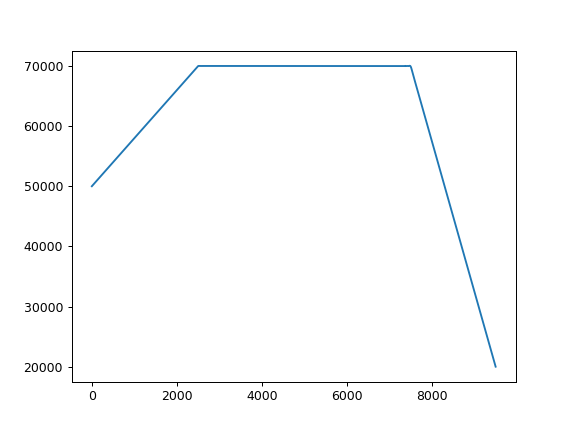

In [433]:
f = make_frequency_profiles({'cf':(70000, 0.01),
                             'upfm':(50000, 0.005),
                              'downfm':(20000,0.004)}, fs=fs,
                               joint_duration=0.00025)
plt.figure()
plt.plot(f)

MAIWOO 374 374
MAIWOO 374 374


<IPython.core.display.Javascript object>


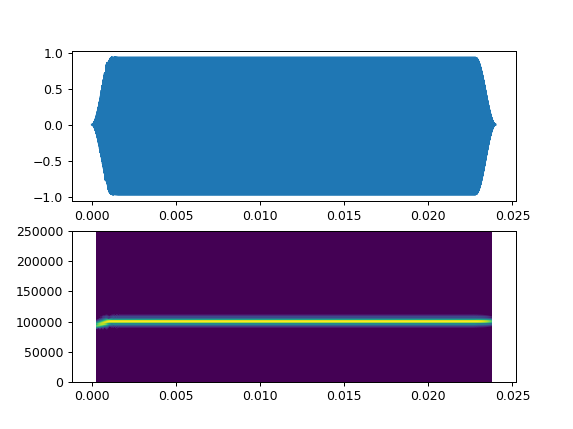

(<matplotlib.axes._subplots.AxesSubplot at 0x67d90708>,
 <matplotlib.axes._subplots.AxesSubplot at 0x67db55c8>)

In [430]:
call_properties = {'cf':(100000, 0.020),
                  'upfm':(90000, 0.001),
                   'downfm':(100000,0.003)}
call ,freq_profile = make_cffm_call(call_properties, fs)
call *= signal.tukey(call.size, alpha=0.1)
visualise_call(call, fs, fft_size=256)

<IPython.core.display.Javascript object>


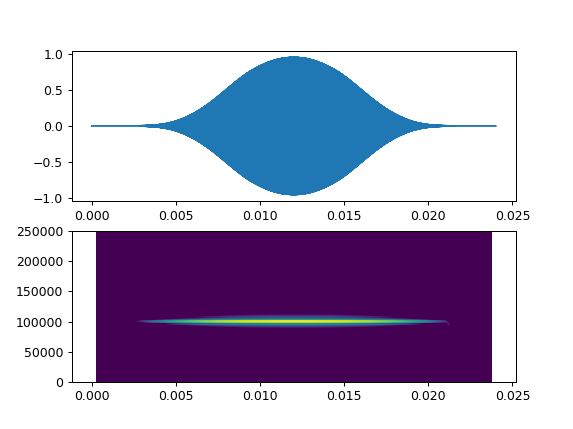

(<matplotlib.axes._subplots.AxesSubplot at 0x62187788>,
 <matplotlib.axes._subplots.AxesSubplot at 0x621bbf08>)

MAIWOO 374 374


<IPython.core.display.Javascript object>


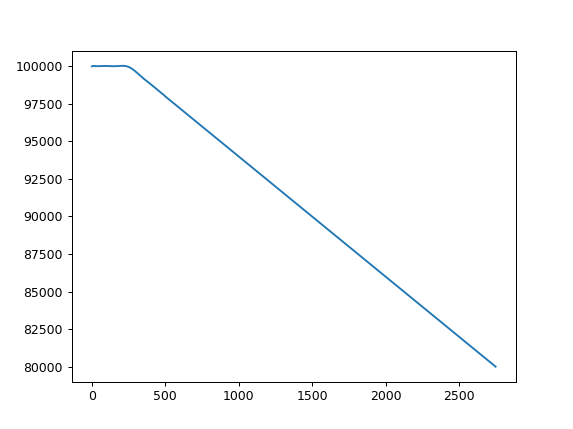

In [368]:
fm, mn = make_FM_with_joint((80000, 0.005), 100000)
plt.figure()
plt.plot(fm)

In [329]:
out = make_cffm_call((50000,0.01),{'down':(30000,0.005),
                                    'up':(40000,0.001)}, fs,)

In [330]:
out['up']

array([], dtype=float64)

<IPython.core.display.Javascript object>


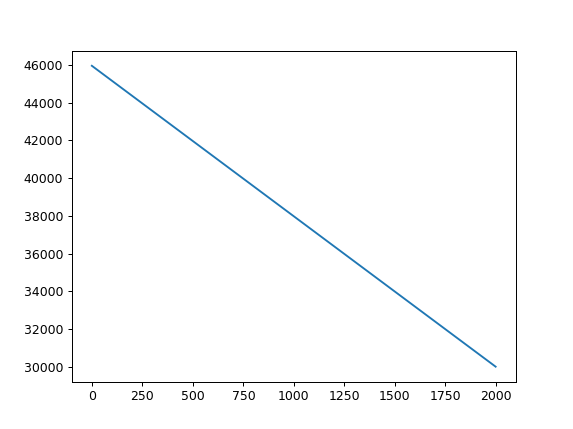

In [331]:
plt.figure()
plt.plot(out['down'])
plt.plot(out['up'])

In [307]:
call ,ff = make_cffm_call([100000, 0.01], [40000, 0.001], fs,)


<IPython.core.display.Javascript object>


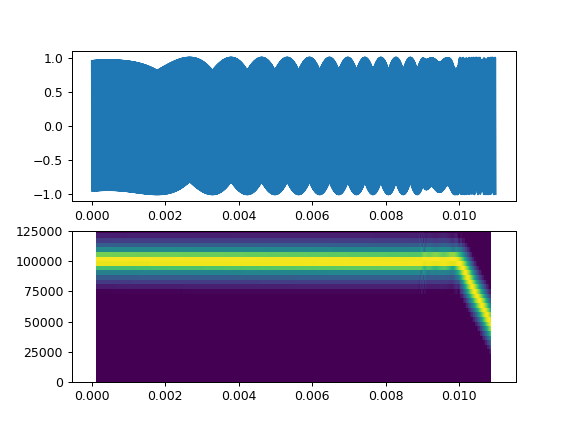

(0, 125000)

In [308]:
w,s = visualise_call(call, fs, fft_size=128)
s.set_ylim(0,125000)

In [258]:
    
min_dur = 0.2*10**-3



final_profile = np.concatenate((pre_joint_cf_freqs, joint_profile, post_joint_fm_freqs))
call = np.sin(2*np.pi*dt*np.cumsum(final_profile)) 

plt.figure()
plt.plot(np.linspace(0,2*min_dur, int(2*min_dur*fs)),joint_profile)

(99971.23426549649, 95975.83678299846)

<IPython.core.display.Javascript object>


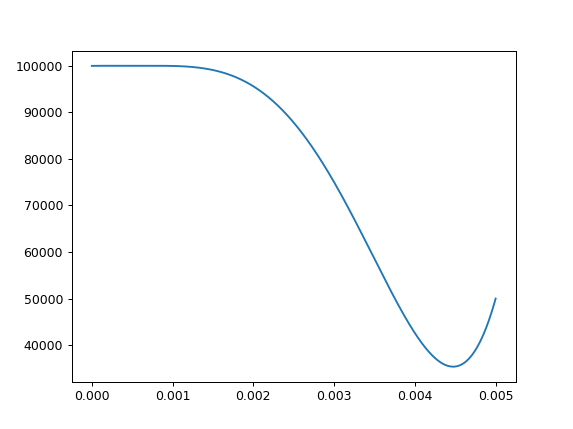

In [270]:

fm_freqs = np.concatenate((np.tile(cf,50),
                           np.array([cf, np.mean([cf,fm_end]),fm_end]))
                         )
times = np.concatenate((np.linspace(0,0.0009,50), 
         np.array([0.001, np.mean([0.001,0.005]), 0.005]))
                      )

fm_intp = np.poly1d(np.polyfit(times, fm_freqs, 5))

fm_time = np.linspace(0,0.005, int(fs*0.005))
fm_freq_profile = fm_intp(fm_time)

cf_freq_profile = np.tile(cf, int(fs*(cf_duration-0.001)))

frequency_over_time = np.concatenate((cf_freq_profile,fm_freq_profile))

signal = np.sin(2*np.pi*dt*np.cumsum(frequency_over_time)) 
plt.figure()
plt.plot(fm_time, fm_freq_profile)

In [272]:
1.0/fs

2e-06

In [271]:
dt

2.000571591883395e-06

<IPython.core.display.Javascript object>


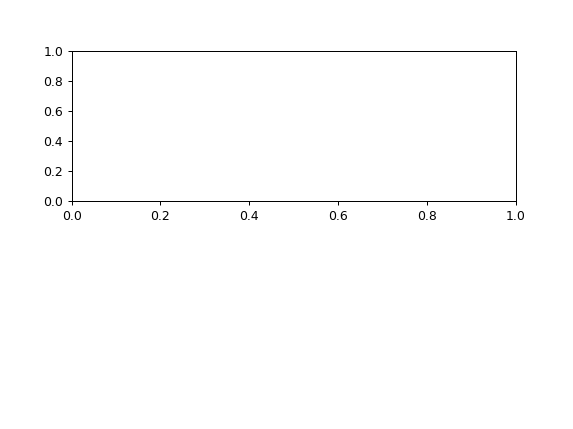

AttributeError: module 'scipy.signal' has no attribute 'size'

In [255]:
w, s = visualise_call(signal,fs, fft_size=512)
s.set_ylim(25000,125000)


<IPython.core.display.Javascript object>


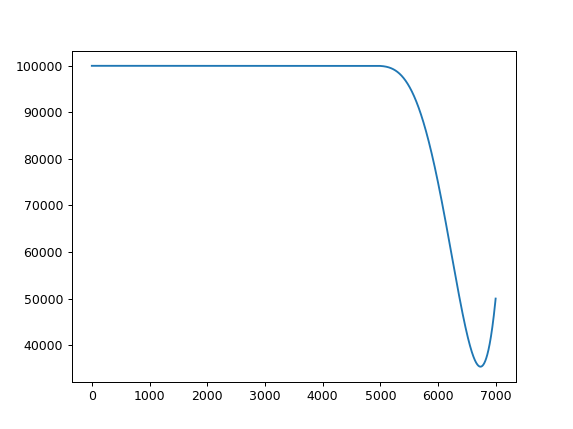

In [186]:
plt.figure()
plt.plot(frequency_over_time)

In [438]:
import scipy.signal as signal 
from measure_horseshoe_bat_calls.user_interface import segment_and_measure_call
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call

# create synthetic call 
call_parameters = {'cf':(100000, 0.01),
                    'upfm':(80000, 0.002),
                    'downfm':(60000, 0.003),
                    }

fs = 500*10**3 # 500kHz sampling rate 
synthetic_call, freq_profile = make_cffm_call(call_parameters, fs) 

# window and reduce overall signal level
synthetic_call *= signal.tukey(synthetic_call.size, 0.1)
synthetic_call *= 0.75
# and add 2ms of additional background_noise of ~ -60dBrms
samples_1ms = int(fs*0.001)
final_size = synthetic_call.size + samples_1ms*2
call_with_noise = np.random.normal(0,10**(-60/20.0),final_size)
call_with_noise[samples_1ms:-samples_1ms] += synthetic_call

# 

seg_and_msmts = segment_and_measure_call(call_with_noise, fs,
                                         segment_from_background=True)
call_segmentation, call_parts, measurements, backg_segment = seg_and_msmts

In [ ]:
make_overview_figure()